# Biblical and Apocryphal Citations in Sermon Marginalia 

In [ ]:
import sys
sys.path.append('../')
from lib.biblical_citations import * 
from lib.visualization import * 
from collections import Counter

In [ ]:
# group = filepath.split("/")[-1].split(".")[0][:2] # "A1"
groups = {"A19":["A19277"],"A4":["A40728"]}

for filename, tcpids in groups.items(): 
    process(filename, tcpids)

## Normalization and Decomposition 

In [3]:
outputs = []
with open('../assets/sermons_marginalia.csv', 'r') as file:          
    notes = csv.reader(file, delimiter=',')

    formatting_outliers = []
    citations, outliers = [],[]
    for idx, entry in enumerate(notes):
        # output dictionary 
        info_dict = {'idx':idx, 'tcpID':entry[0],'citations':None, 'outliers':None,'original':entry[-1]}
        # get note text 
        n = entry[-1]
        n = clean_text(n)
        # find possible citations 
        n = replaceBook(n)
        match = re.findall(r'([a-z*]+ [\d*\,\&\-\— ]+)', n)
        c,o = [],[]
        if len(match) > 0: 
            for item in match:
                item = re.sub(r"([^0-9a-z*])$","",item)
                item = item.split(" ")
                book = item[0]
                if len(item) == 2 and item[1] == "&":
                    continue # trivial case of "<word> &"
                if len(item) == 1: 
                    continue 
                item = " ".join(item)
                if book not in abbrev and book not in numBook.values():
                    o.append(item)
                else: 
                    if re.search('samuel|kings|chronicles|corinthians|thessalonians|timothy|peter',book):
                        if book not in numBook.values(): 
                            continue
                            # false positive cases of numbered book citations, e.g., "3. The •"
                    decomposed = findCitations(item)
                    c.extend(decomposed[0])
                    o.extend(decomposed[1])
                    formatting_outliers.extend(decomposed[1])                     
            info_dict['citations'] = "; ".join(c) 
            info_dict['outliers'] = "; ".join(o)
            outputs.append(info_dict)
            citations.extend(c)
            outliers.extend(o)
        if (idx+1) % 100000 == 0: 
            print(f"Processed {idx+1} entries")


outfile = open("../outputs/citations.csv","w+")
writer = csv.DictWriter(outfile, fieldnames=["idx","tcpID","citations","outliers","original"])
writer.writeheader()
for dict in outputs: 
    writer.writerow(dict)
outfile.close()

Processed 100000 entries
Processed 200000 entries
Processed 300000 entries
Processed 400000 entries
Processed 500000 entries
Processed 600000 entries


# Corruption and Uncertainty 

### Chapter and Verse Level

In [61]:
catalog = {}
for dict in outputs: 
    cited = dict["citations"].split("; ")
    tcpID = dict["tcpID"]
    if len(cited) == 0: continue
    for c in cited: 
        if len(c) == 0: continue
        c = c.split(" ")
        if tcpID not in catalog: 
            catalog[tcpID] = {'only_chapter':0,'verse':0,'corrupted_book':0,'corrupted_ch_only':0,'corrupted_v_only':0,'all_corrupt':0}
        if re.match(r'[\d\*]',c[0]): # numbered book with unknown number
            if c[0] == '*': 
                catalog[tcpID]['corrupted_book'] += 1 
                continue
            book = f"{c[0]} {c[1]}"
            ref = c[2]
        else: 
            book = c[0]
            ref = c[1]
        ref = ref.split(".")
        chapter = ref[0]
        if "*" in chapter and len(ref) < 2: 
            # chapter-only citations with illegible characters 
            catalog[tcpID]['corrupted_ch_only'] += 1 
        elif len(ref) == 2: 
            verse = ref[1] 
            if "*" in verse: 
                if '*' in chapter: 
                    # both chapter and verse are uncertain 
                    catalog[tcpID]['all_corrupt'] += 1 
                else: 
                    # verse is uncertain 
                    catalog[tcpID]['corrupted_v_only'] += 1 
            else: 
                catalog[tcpID]['verse'] += 1 
        else: 
            catalog[tcpID]['only_chapter'] += 1 

for tcpID, dict in catalog.items():
    corrupt = dict["all_corrupt"] + dict["corrupted_v_only"] + dict["corrupted_ch_only"] + dict["corrupted_book"]
    total = dict["verse"] + corrupt + dict["only_chapter"]
    corrupt_ratio = 0 
    if total > 0: 
        corrupt_ratio = corrupt/total
    catalog[tcpID]['corrupt_ratio'] = corrupt_ratio 
    catalog[tcpID]['total'] = total
    
sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ratio'],
                                                 catalog[x]['total']),reverse=True)

Counts

In [63]:
total = sum(catalog[tcpID]['total'] for tcpID in catalog)
clean_ch = sum(catalog[tcpID]['only_chapter'] for tcpID in catalog)
clean_v = sum(catalog[tcpID]['verse'] for tcpID in catalog)
corrupted_book = sum([dict['corrupted_book'] for dict in catalog.values()])
corrupted_ch = sum([dict['corrupted_ch_only'] for dict in catalog.values()])
corrupted_v = sum([dict['corrupted_v_only'] for dict in catalog.values()])
all_corrupt = sum([dict['all_corrupt'] for dict in catalog.values()])
total_corrupted = corrupted_ch + corrupted_v + all_corrupt + corrupted_book
print(f"{total} total citations, with {total_corrupted} ({round((total_corrupted)/total,ndigits=2)*100}%) corrupted")
print(f"Of uncorrupted book citations, {clean_ch + corrupted_ch} ({round((clean_ch+corrupted_ch)/total,ndigits=4)*100}%) are chapter-level and {clean_v+corrupted_v+all_corrupt} ({round((clean_v+corrupted_v+all_corrupt)/total,ndigits=3)*100}%) are verse-level")
print(f"\t{corrupted_ch} ({round((corrupted_ch)/(clean_ch+corrupted_ch),ndigits=3)*100}%) chapter-only citations are corrupted")
print(f"\t{corrupted_v} ({round((corrupted_v)/(clean_v+corrupted_v+all_corrupt),ndigits=2)*100}%) verse citations are corrupted")
print(f"\t{all_corrupt}  ({round((all_corrupt)/(clean_v+corrupted_v+all_corrupt),ndigits=3)*100}%) citations are corrupted in both chapter and verse")
print(f"Of numbered book citations, {corrupted_book} ({round((corrupted_book)/total,ndigits=4)*100}%) are corrupted")

480266 total citations, with 12328 (3.0%) corrupted
Of uncorrupted book citations, 65389 (13.62%) are chapter-level and 413502 (86.1%) are verse-level
	2962 (4.5%) chapter-only citations are corrupted
	7160 (2.0%) verse citations are corrupted
	831  (0.2%) citations are corrupted in both chapter and verse
Of numbered book citations, 1375 (0.29%) are corrupted


In [67]:
not_corrupted = []
low_corruption = []
high_corruption = []
for tcpID in sorted_catalog: 
    if catalog[tcpID]['corrupt_ratio'] == 0: 
        not_corrupted.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] < 0.1: 
        low_corruption.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] > 0.4: 
        high_corruption.append(tcpID)
print(len(not_corrupted), "texts without corrupted citations",len(low_corruption),"texts with a small proportion of corrupted citations")
print(len(high_corruption), "texts with a high ratio of corrupted citations")
print(len(sorted_catalog) - (len(not_corrupted) + len(low_corruption) + len(high_corruption)),'texts with a moderate ratio of corrupted citations')

1919 texts without corrupted citations 1483 texts with a small proportion of corrupted citations
23 texts with a high ratio of corrupted citations
259 texts with a moderate ratio of corrupted citations


Save stats to csv

In [68]:
outfile = open("../outputs/stats.csv","w+")
writer = csv.DictWriter(outfile, fieldnames=["tcpID", "only_chapter","verse","corrupted_book","corrupted_ch_only","corrupted_v_only","all_corrupt","corrupt_ratio","total"])
writer.writeheader()
for tcpID in sorted_catalog: 
    dict = catalog[tcpID]
    dict['tcpID'] = tcpID
    writer.writerow(dict)
outfile.close()

### Book Level

In [69]:
'''Standardize abbreviations'''
num_to_text = {'1':'one','2':'two','3':'three'}
def findAbbrev(note): 
    note = note.split(" ")
    for idx, word in enumerate(note): 
        if re.search(r"^de",word): 
            if idx+1 in range(len(note)): 
                # 'de' must be followed by at least one number to be considered an abbreviation  
                if not re.match(r'\b[0-9*]+\b',note[idx+1]): 
                    continue 
        note[idx] = convert_numeral(word)
        word = clean_word(word)
        # identififed a valid abbreviation         
        if word in abbrev_to_book:
            # update term to the normalized version 
            word = abbrev_to_book[word]
            # non-scriptural references to an epistle
            if word == 'epistle' and idx > 0:
                continue
            elif re.search('samuel|kings|chronicles|corinthians|thessalonians|timothy|peter',word): 
                # do not convert 'ch' or 'the' if it is not preceded by a number or an asterisk 
                if idx > 0: 
                    if not re.search(r'^[1-3\*{1}]',note[idx-1]):
                        continue   
            note[idx] = word  
    return note

In [70]:
from collections import defaultdict

abbrev_hits = defaultdict(list)
with open('../assets/sermons_marginalia.csv', 'r') as file:          
    notes = csv.reader(file, delimiter=',')
    
    for i, entry in enumerate(notes):
        n = entry[-1]
        orig_note = clean_text(n)
        note = findAbbrev(orig_note)
        orig_note = orig_note.split(" ")
        for idx in range(len(note)-1):
            if note[idx] in abbrev: 
                if re.match(r"^[^a-z]+$", note[idx+1]) and len(note[idx+1]) > 0:
                    abbrev_hits[note[idx]].append(clean_word(orig_note[idx]))
        if (i+1) % 100000 == 0: 
            print(f"Processed {i+1} entries")

Processed 100000 entries
Processed 200000 entries
Processed 300000 entries
Processed 400000 entries
Processed 500000 entries
Processed 600000 entries


In [71]:
abbrev_counts = {}
import json
for book, ab in abbrev_hits.items(): 
    abbrev_counts[book] = {k:v for k,v in Counter(ab).items()}
with open(f"../outputs/abbreviations.json",'w+') as file: 
    json.dump(abbrev_counts, file)

In [72]:
sum([len(d) for d in abbrev_counts.values()])

1539

# Visualizations 

In [81]:
all_books = {}
all_chapters = {}
all_verses = {}
for dict in outputs: 
    cited = dict["citations"].split("; ")
    tcpID = dict["tcpID"]
    if len(cited) == 0: continue
    for c in cited: 
        if len(c) == 0: continue
        c = c.split(" ")
    
        if re.match(r'[\d\*]',c[0]): 
            # numbered book with unknown number
            if c[0] == '*':  
                continue
            book = f"{c[0]} {c[1]}"
            ref = c[2]
        else: 
            book = c[0]
            ref = c[1]
        
        if book not in all_books: all_books[book] = 0
        all_books[book] += 1 

        ref = ref.split(".")
        chapter = ref[0]
        if '*' not in chapter: 
            key = f"{book} {chapter}"
            if key not in all_chapters: 
                all_chapters[key] = 0
            all_chapters[key] += 1 
            if len(ref) == 2: 
                verse = ref[1]
                if '*' not in verse: 
                    key = f"{book} {chapter}.{verse}"
                    if key not in all_verses: 
                        all_verses[key] = 0
                    all_verses[key] += 1 

[('Psalms', 50702), ('Matthew', 34501), ('Romans', 24663), ('Isaiah', 22810), ('John', 21183), ('Luke', 20279), ('1 Corinthians', 18197), ('Acts', 17850), ('Genesis', 17697), ('Hebrews', 15505), ('Proverbs', 13084), ('Revelation', 11534), ('Job', 11035), ('Ephesians', 10921), ('2 Corinthians', 10314), ('Jeremiah', 10303), ('Exodus', 9341), ('Deuteronomy', 7634), ('1 Peter', 7277), ('Galatians', 7087), ('1 Samuel', 6544), ('Philippians', 6361), ('1 Timothy', 6148), ('Ecclesiastes', 5962), ('1 Kings', 5915), ('Ezekiel', 5774)]


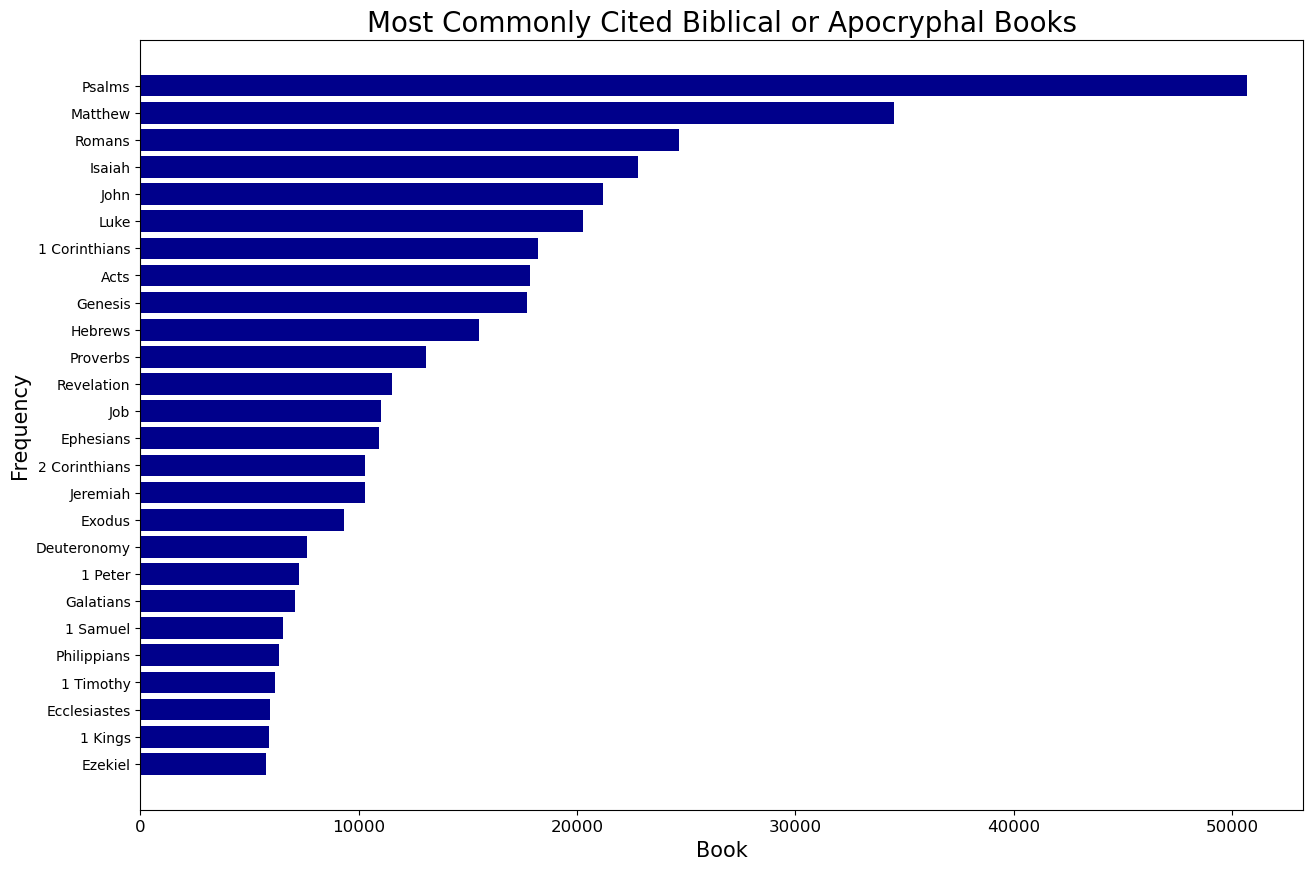

In [82]:
x,y = [],[]
counts = sorted(all_books.items(), key=lambda x:x[1],reverse=True)
print(counts[:26])
for word,freq in reversed(counts[:26]): 
    x.append(word)
    y.append(freq)
bar('horizontal',(x,y),'Most Commonly Cited Biblical or Apocryphal Books','darkblue',('Book','Frequency'))

[('Romans 8', 4144), ('Matthew 5', 3061), ('Ephesians 4', 2857), ('Psalms 119', 2721), ('Hebrews 12', 2275), ('1 Corinthians 15', 2236), ('1 Peter 2', 2199), ('Philippians 3', 2077), ('Ephesians 2', 2072), ('Matthew 25', 2011), ('2 Corinthians 5', 2002), ('Hebrews 11', 1999), ('Romans 1', 1996), ('Matthew 26', 1958), ('John 1', 1956), ('1 Peter 1', 1936), ('Philippians 2', 1913), ('John 3', 1910), ('Ephesians 5', 1888), ('Matthew 7', 1867), ('Hebrews 10', 1850), ('Matthew 6', 1837), ('Romans 5', 1837), ('Genesis 3', 1799), ('Romans 6', 1763), ('Romans 13', 1743)]


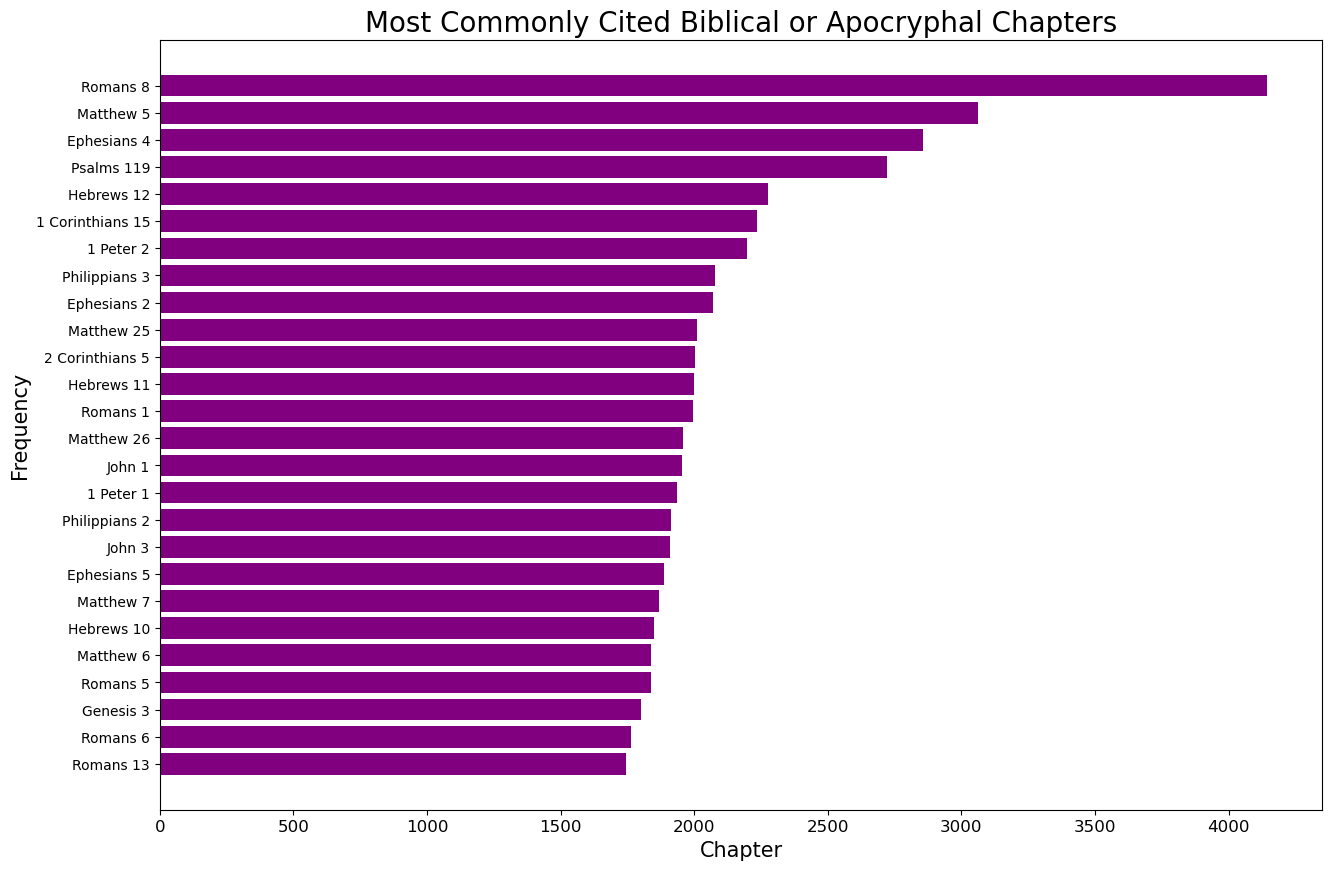

In [83]:
x,y = [],[]
counts = sorted(all_chapters.items(), key=lambda x:x[1],reverse=True)
print(counts[:26])
for word,freq in reversed(counts[:26]): 
    x.append(word)
    y.append(freq)
bar('horizontal',(x,y),'Most Commonly Cited Biblical or Apocryphal Chapters','purple',('Chapter','Frequency'))

[('John 3.16', 299), ('Romans 13.1', 294), ('James 1.17', 292), ('Philippians 3.8', 274), ('Genesis 3.15', 260), ('Isaiah 9.6', 259), ('Galatians 2.20', 251), ('Romans 13.4', 248), ('1 Peter 5.8', 247), ('2 Corinthians 5.20', 243), ('1 Peter 2.13', 240), ('Romans 8.28', 240), ('Matthew 11.28', 232), ('Romans 6.23', 227), ('2 Peter 1.4', 227), ('Romans 7.24', 225), ('2 Timothy 4.8', 222), ('Romans 2.5', 222), ('Acts 20.28', 222), ('1 Corinthians 2.14', 221), ('Psalms 82.6', 221), ('Matthew 28.19', 220), ('1 Corinthians 1.30', 217), ('Hebrews 12.2', 213), ('Hebrews 1.3', 213), ('Hebrews 4.12', 210)]


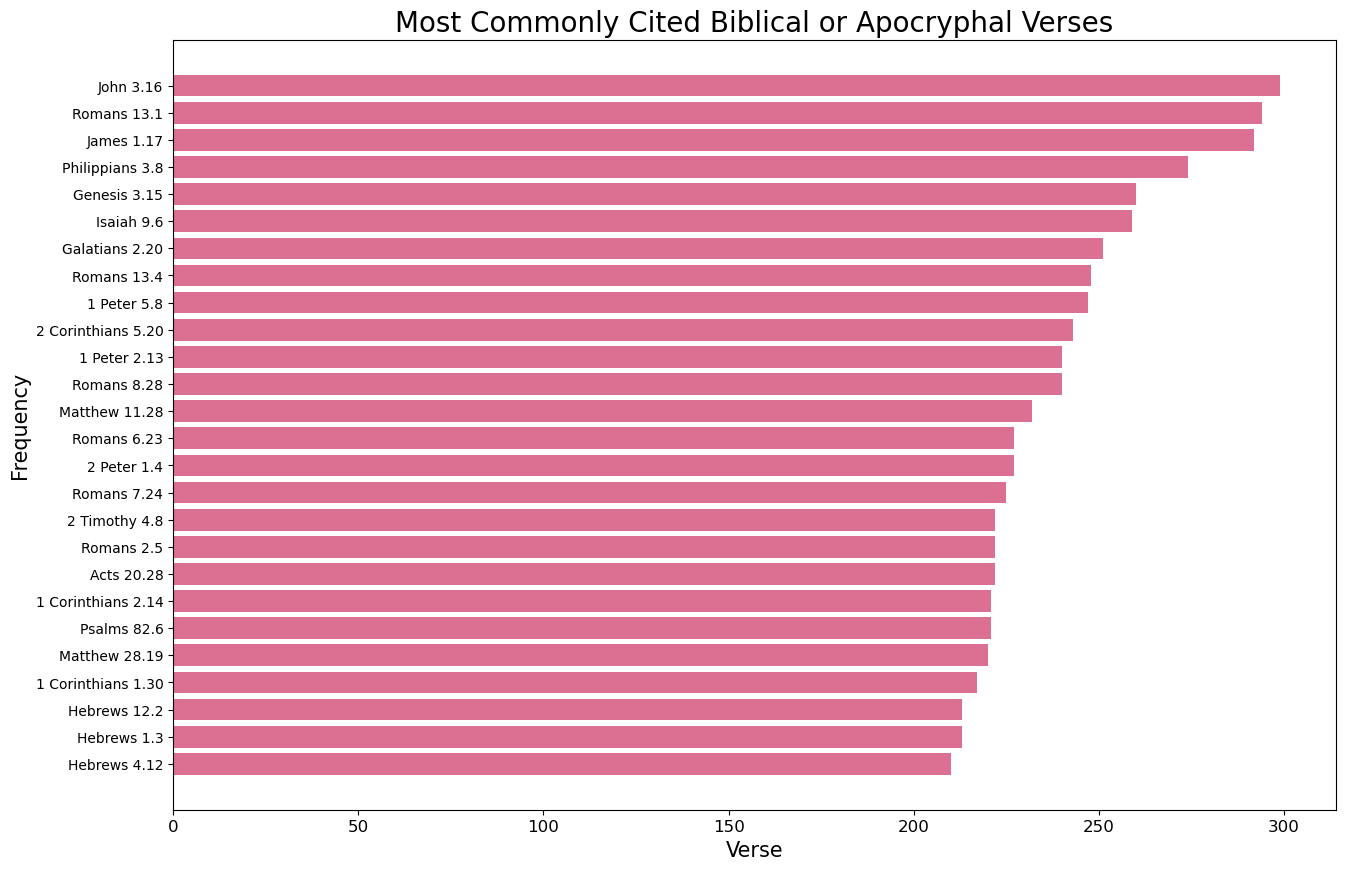

In [84]:
x,y = [],[]
counts = sorted(all_verses.items(), key=lambda x:x[1],reverse=True)
print(counts[:26])
for word,freq in reversed(counts[:26]): 
    x.append(word)
    y.append(freq)
bar('horizontal',(x,y),'Most Commonly Cited Biblical or Apocryphal Verses','palevioletred',('Verse','Frequency'))

## Misc

In [ ]:
# for tcpID, dict in catalog.items():
#     corrupt_verses = dict["all_corrupt"] + dict["corrupted_v_only"]
#     corrupt_chapters = dict["corrupted_ch_only"]
#     total_verses = dict["verse"]+corrupt_verses
#     total_chapters = dict["only_chapter"]+corrupt_chapters
#     if total_verses > 0: 
#         v_ratio = corrupt_verses/total_verses
#     if total_chapters > 0: 
#         c_ratio = corrupt_chapters/total_chapters
#     catalog[tcpID]['corrupt_ch_ratio'] = c_ratio 
#     catalog[tcpID]['corrupt_v_ratio'] = v_ratio 
# sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ch_ratio'], 
#                                                 catalog[x]['corrupt_v_ratio']))
# for tcpID in reversed(sorted_catalog): 
#     print(catalog[tcpID])

In [108]:
for item in formatting_outliers: 
    if len(item.split(" ")) > 2: 
        print(item)

amos 8 4 5-11
nehemiah 2 4-4 4-4 9-5 19-6 14-13 14-22-29
nehemiah 1 8-6 14-13 14-22-29-31
john 19 1-6-15
acts 14 14 15-8
revelation 7 7 8-10 11
11 4, 5, 7 8, 20, 21, 33-34
acts 2 24 32 3 15, 26 4 10 5 30 13-30, 33
john 5 24 3-18
hebrews 10 32-34 11 24-26
onepeter onepeter 4 12-19 3 14-17
twothessalonians 3 7 9-8
psalms 113 5 *-7
psalms 62 11-2-79 12
unknownpeter 2 19 20-26
onecorinthians onecorinthians 5 1 9-11 6 9-18 7 1
leviticus 4 3 29 33-5 6, 7 9 11-9 22-12 6, 8-14 13-16 16
matthew 17 10 11-11 14
psalms 42 3-10-69 19 80 5 6-89 50, 51-123 3, 4
onetimothy 1 4 6-2 7
genesis 30 35-37 13 14-42 1, 2, 3-43 15-47 1, 2, 3
john 14 1 15 11-16 33
onesamuel 20 30 33-22 8
psalms 25-94-55-42 143 2, 3
psalms 62 11-12-79 12
3 24 5, 15-17
revelation 3 5 21-21 7-22 5
90 5, 7, 8,-11
ecclesiasticus 33 5 7-13
jeremiah 9 5 2-8
james 2 5 1-4
twocorinthians 2 17-,
luke 24 9 10-50 51
2 12, 14,-19
onecorinthians onecorinthians 51 9-11 6 9-18 7 1,


In [57]:
# from collections import Counter
# from difflib import SequenceMatcher
# possible_abbrev = []
# for o in outliers: 
#     possible_abbrev.append(o.split(" ")[0]) 

# possible_abbrev = Counter(possible_abbrev).items()
# possible_matches = {k:[] for k in abbrev}
# for word,freq in possible_abbrev:
#     # print(word)
#     # finding possible matches to any of the known abbreviations for each book
#     if word not in abbrev_to_book: 
#         for ab, book in abbrev_to_book.items():
#             similarity = SequenceMatcher(None, ab, word).ratio()
#             if similarity >= 0.8:
#                 possible_matches[book].append((word,freq))
#                 break

In [58]:
# clean_format = []
# for book, variants in possible_matches.items(): 
#     for v,freq in variants:
#         clean_format.append(f"{book}: {v} {freq}\n") 
#     clean_format.append("\n")
# with open(f"../assets/possible_variants_2.txt","w+") as file: 
#     file.writelines(clean_format)

In [ ]:
# with open(f"../assets/possible_variants_2 copy.txt","r") as file: 
#     lines = file.readlines() 
# for line in lines: 
#     line = line.split(" ")
#     b, ab = line[0].strip(":"), line[1]
#     abbrev[b].append(ab)
# count = 0 
# for b,ab_list in abbrev.items(): 
#     print(f"'{b}':")
#     print("[")
#     for ab in sorted(set(ab_list)): 
#         print(f"\t'{ab}',")
#     print(f"],")